# 🚀 Battery Swap Routing Optimizer

## 📦 Imports and Configuration

In [1]:
import pandas as pd
import random
import pytz
from datetime import datetime, timedelta

## 📍 Rider and Station Simulation

In [2]:
# Generating the dataset
random.seed(104)

# Step 1: Generate 'rider_id' column for 100 riders

# Rider IDs from R001 to R100
rider_ids = [f"R{str(i).zfill(3)}" for i in range(1, 101)]

# Create a DataFrame
riders_df = pd.DataFrame({"rider_id": rider_ids})

# Step 2: Generate 'lat' and 'lng' near Pune
BASE_LAT = 18.5204
BASE_LNG = 73.8567
DELTA = 0.01  # ~1 km variation in all directions

# Generate coordinates
riders_df["lat"] = [BASE_LAT + random.uniform(-DELTA, DELTA) for _ in range(len(riders_df))]
riders_df["lng"] = [BASE_LNG + random.uniform(-DELTA, DELTA) for _ in range(len(riders_df))]

# Step 3: Generate 'soc_pct' (battery percentage)

# Random integer between 10% and 100%
riders_df["soc_pct"] = [random.randint(10, 100) for _ in range(len(riders_df))]

# Step 4: Assign 'status' based on 7 PM peak time for a Blinkit-like company
# 70% chance of being 'on_gig', 30% chance of being 'idle'

riders_df["status"] = [random.choices(["on_gig", "idle"], weights=[0.7, 0.3])[0] for _ in range(len(riders_df))]

# Step 5: Add 'km_to_finish' and 'est_finish_ts' for on_gig riders

# Define IST timezone using pytz
ist = pytz.timezone("Asia/Kolkata")

# Step 1: Define 7:00 PM IST on May 22, 2025
ist_time = ist.localize(datetime(2025, 5, 22, 19, 0, 0))

# Step 2: Convert IST time to UTC
now_utc = ist_time.astimezone(pytz.UTC)

km_to_finish_list = []
est_finish_ts_list = []

for status in riders_df["status"]:
    if status == "on_gig":
        km = round(random.uniform(1.0, 6.0), 2)
        finish_time = now_utc + timedelta(minutes=int(km * 3))  # 20 km/h → 3 min per km
        km_to_finish_list.append(km)
        est_finish_ts_list.append(finish_time.isoformat() + "Z")
    else:
        km_to_finish_list.append(None)
        est_finish_ts_list.append(None)

riders_df["km_to_finish"] = km_to_finish_list
riders_df["est_finish_ts"] = est_finish_ts_list


In [28]:
random.seed(100)
# Constants
BASE_LAT = 18.5204
BASE_LNG = 73.8567
STATION_DELTA = 0.01
station_ids = ["S_A", "S_B", "S_C"]
SWAP_TIME_MIN = 4
NOW_UTC = datetime.strptime("2025-05-22T13:30:00Z", "%Y-%m-%dT%H:%M:%SZ")

def next_available_slot(slots):
    """
    Return the index of the slot (0-4) that will be free the earliest.
    """
    end_times = [
        max(times) + timedelta(minutes=SWAP_TIME_MIN) if times else random.choices([NOW_UTC,NOW_UTC+timedelta(minutes=1),NOW_UTC+timedelta(minutes=2)],[0.3,0.3,0.3])[0]
        for times in slots
    ]
    return end_times.index(min(end_times)), min(end_times)

# Generate station data
station_data = []

for station_id in station_ids:
    lat = BASE_LAT + random.uniform(-STATION_DELTA, STATION_DELTA)
    lng = BASE_LNG + random.uniform(-STATION_DELTA, STATION_DELTA)
    queue_len = random.randint(0, 10)

    # Initialize 5 empty slots (each slot is a list of swap start times)
    slots = [[] for _ in range(5)]

    for _ in range(queue_len):
        slot_idx, available_at = next_available_slot(slots)
        slots[slot_idx].append(available_at)

    # Flatten into dictionary with slot_1, ..., slot_5
    station_row = {
        "station_id": station_id,
        "lat": lat,
        "lng": lng,
    }
    for i in range(5):
        station_row[f"slot_{i+1}"] = slots[i]

    station_data.append(station_row)

stations_df = pd.DataFrame(station_data)


## 📊 EDA of the Simulated Data

In [4]:
riders_df.head()

,rider_id,lat,lng,soc_pct,status,km_to_finish,est_finish_ts
0,R001,18.529599,73.850703,25,on_gig,2.29,2025-05-22T13:36:00+00:00Z
1,R002,18.527837,73.847793,76,on_gig,3.26,2025-05-22T13:39:00+00:00Z
2,R003,18.525038,73.856825,96,idle,NaN,None
3,R004,18.514952,73.851282,51,on_gig,5.35,2025-05-22T13:46:00+00:00Z
4,R005,18.517013,73.857316,70,on_gig,5.62,2025-05-22T13:46:00+00:00Z


In [6]:
riders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   rider_id       100 non-null    object 
 1   lat            100 non-null    float64
 2   lng            100 non-null    float64
 3   soc_pct        100 non-null    int64  
 4   status         100 non-null    object 
 5   km_to_finish   71 non-null     float64
 6   est_finish_ts  71 non-null     object 
dtypes: float64(3), int64(1), object(3)
memory usage: 5.6+ KB


In [5]:
riders_df['status'].value_counts()

,count
status,
on_gig,71
idle,29


In [7]:
stations_df.head()

,station_id,lat,lng,slot_1,slot_2,slot_3,slot_4,slot_5
0,S_A,18.513313,73.855799,[2025-05-22 13:30:00],[],[2025-05-22 13:31:00],[],[]
1,S_B,18.529342,73.853407,[2025-05-22 13:31:00],[2025-05-22 13:31:00],[2025-05-22 13:30:00],[2025-05-22 13:30:00],[]
2,S_C,18.523169,73.850313,[2025-05-22 13:32:00],"[2025-05-22 13:30:00, 2025-05-22 13:34:00]","[2025-05-22 13:30:00, 2025-05-22 13:34:00]","[2025-05-22 13:30:00, 2025-05-22 13:34:00]","[2025-05-22 13:31:00, 2025-05-22 13:35:00]"


In [8]:
# Exporting the simulated data for usage
stations_df.to_csv('stations_df.csv', index=False)
riders_df.to_csv('riders_df.csv', index=False)

## Visualisation of Riders and Stations


In [29]:
import plotly.express as px
import pandas as pd

# Add 'type' column to distinguish riders and stations
riders_plot_df = riders_df.copy()
riders_plot_df["type"] = "Rider"
riders_plot_df["id"] = riders_plot_df["rider_id"]

stations_plot_df = stations_df.copy()
stations_plot_df["type"] = "Station"
stations_plot_df["id"] = stations_plot_df["station_id"]

# Combine both into one DataFrame for plotting
plot_df = pd.concat([riders_plot_df[["lat", "lng", "type", "id"]],
                     stations_plot_df[["lat", "lng", "type", "id"]]])

# Plot using Plotly
fig = px.scatter_mapbox(
    plot_df,
    lat="lat",
    lon="lng",
    color="type",
    hover_name="id",
    zoom=13,
    height=600,
    mapbox_style="carto-positron",
    title="Rider and Station Locations (Pune)"
)

fig.show()


## 🔋 Swap Need Logic

In [30]:
def flag_riders_needing_swap(df, threshold=20, soc_min=10, avg_speed_kmph=25):
    projected_socs = []
    needs_swap_end = []
    needs_swap_midway = []
    swap_reasons = []

    for idx, row in df.iterrows():
        soc = row["soc_pct"]

        if row["status"] == "idle":
            projected_soc = soc
            end_needed = soc <= threshold
            projected_socs.append(projected_soc)
            needs_swap_end.append(end_needed)
            needs_swap_midway.append(False)

            swap_reason = "idle_low_soc" if end_needed else "idle_soc_ok"

        else:  # on_gig
            km_left = row["km_to_finish"]
            projected_soc = soc - (4 * km_left)

            # End-swap needed
            end_needed = projected_soc <= threshold

            # Midway check: if they dip below min (e.g., 10%) before delivery ends
            km_until_critical = (soc - soc_min) / 4
            midway_critical = km_until_critical < km_left

            needs_swap_end.append(end_needed)
            needs_swap_midway.append(midway_critical)
            projected_socs.append(projected_soc)

            if midway_critical:
                swap_reason = "midway_soc_critical"
            elif end_needed:
                swap_reason = "low_soc_at_end"
            else:
                swap_reason = "trip_possible_without_swap"

        swap_reasons.append(swap_reason)

    df["projected_soc"] = projected_socs
    df["needs_swap_end"] = needs_swap_end
    df["needs_swap_midway"] = needs_swap_midway
    df["needs_swap"] = df["needs_swap_end"] | df["needs_swap_midway"]
    df["swap_reason"] = swap_reasons

    return df

# Step 3: Apply the function
riders_df_need_swap = flag_riders_needing_swap(riders_df)


In [25]:
# analysing the newly created riders_df_need_swap
riders_df_need_swap.head()

,rider_id,lat,lng,soc_pct,status,km_to_finish,est_finish_ts,projected_soc,needs_swap_end,needs_swap_midway,needs_swap,swap_reason,assigned,max_travel_km,reason_for_no_swap
0,R001,18.529599,73.850703,25,on_gig,2.29,2025-05-22T13:36:00+00:00Z,15.84,True,False,True,low_soc_at_end,True,6.25,None
1,R002,18.527837,73.847793,76,on_gig,3.26,2025-05-22T13:39:00+00:00Z,62.96,False,False,False,trip_possible_without_swap,False,19.00,None
2,R003,18.525038,73.856825,96,idle,NaN,None,96.00,False,False,False,idle_soc_ok,False,24.00,None
3,R004,18.514952,73.851282,51,on_gig,5.35,2025-05-22T13:46:00+00:00Z,29.60,False,False,False,trip_possible_without_swap,False,12.75,None
4,R005,18.517013,73.857316,70,on_gig,5.62,2025-05-22T13:46:00+00:00Z,47.52,False,False,False,trip_possible_without_swap,False,17.50,None


In [26]:
riders_df_need_swap['needs_swap'].value_counts()

,count
needs_swap,
False,71
True,29


In [31]:
riders_df_need_swap[['needs_swap','swap_reason']].value_counts()

needs_swap  swap_reason               
False       trip_possible_without_swap    45
            idle_soc_ok                   26
True        midway_soc_critical           15
            low_soc_at_end                11
            idle_low_soc                   3
Name: count, dtype: int64

In [14]:
riders_df_need_swap[riders_df_need_swap['needs_swap'] == True]

,rider_id,lat,lng,soc_pct,status,km_to_finish,est_finish_ts,projected_soc,needs_swap_end,needs_swap_midway,needs_swap,swap_reason
0,R001,18.529599,73.850703,25,on_gig,2.29,2025-05-22T13:36:00+00:00Z,15.84,True,True,True,midway_soc_critical
11,R012,18.523507,73.854606,17,idle,NaN,None,17.00,True,False,True,idle_low_soc
18,R019,18.522829,73.862176,16,idle,NaN,None,16.00,True,False,True,idle_low_soc
24,R025,18.513994,73.862222,31,on_gig,5.50,2025-05-22T13:46:00+00:00Z,9.00,True,True,True,midway_soc_critical
26,R027,18.512406,73.855884,23,on_gig,4.47,2025-05-22T13:43:00+00:00Z,5.12,True,True,True,midway_soc_critical
32,R033,18.528868,73.864341,26,on_gig,5.07,2025-05-22T13:45:00+00:00Z,5.72,True,True,True,midway_soc_critical
34,R035,18.530231,73.850260,14,on_gig,5.23,2025-05-22T13:45:00+00:00Z,-6.92,True,True,True,midway_soc_critical
36,R037,18.527215,73.862655,11,on_gig,4.32,2025-05-22T13:42:00+00:00Z,-6.28,True,True,True,midway_soc_critical
38,R039,18.523752,73.860391,16,on_gig,1.84,2025-05-22T13:35:00+00:00Z,8.64,True,True,True,midway_soc_critical
41,R042,18.523054,73.855459,34,on_gig,4.09,2025-05-22T13:42:00+00:00Z,17.64,True,True,True,midway_soc_critical


## ⚙️ Swap Assignment Optimizer

In [32]:
from geopy.distance import geodesic
from datetime import datetime, timedelta
import pandas as pd

# --- CONFIGURATION ---
SWAP_TIME_MIN = 4
MAX_SLOTS = 5
SPEED_KMPH = 25
SOC_THRESHOLD = 20
NOW_UTC = datetime.strptime("2025-05-22T13:30:00Z", "%Y-%m-%dT%H:%M:%SZ")

# --- FILTER RIDERS THAT NEED SWAP ---
swap_riders = riders_df_need_swap[riders_df_need_swap["needs_swap"] == True].copy()
swap_riders["est_finish_ts"] = pd.to_datetime(swap_riders["est_finish_ts"], errors='coerce')

# --- PRIORITY RULES ---
def assign_priority(r):
    if r.get("needs_swap_midway", False):
        return 0
    elif r["status"] == "idle" and r["soc_pct"] < SOC_THRESHOLD:
        return 1
    elif r["status"] == "idle":
        return 2
    else:
        return 3

swap_riders["priority"] = swap_riders.apply(assign_priority, axis=1)
swap_riders = swap_riders.sort_values(by=["priority", "soc_pct", "est_finish_ts"], ascending=[True, True, True])

# --- SLOT FINDING FUNCTION ---
def find_best_slot(station_row, arrive_time):
    best_slot = None
    best_start_time = None
    min_start_time = datetime.max

    for i in range(1, MAX_SLOTS + 1):
        slot_key = f"slot_{i}"
        scheduled = station_row[slot_key]

        if scheduled:
            last_end = max(scheduled) + timedelta(minutes=SWAP_TIME_MIN)
            start_time = max(arrive_time, last_end)
        else:
            start_time = arrive_time

        if start_time < min_start_time:
            best_slot = slot_key
            best_start_time = start_time
            min_start_time = start_time

    return best_slot, best_start_time

# --- MAIN OPTIMIZER LOOP ---
plan_output = []
assigned_ids = set()

for idx, rider in swap_riders.iterrows():
    rider_loc = (rider["lat"], rider["lng"])
    soc = rider["soc_pct"]
    status = rider["status"]
    km_left = rider.get("km_to_finish", 0)
    max_travel_km = soc / 4
    best_plan = None
    min_total_minutes = float("inf")

    # --- Determine available time ---
    if rider.get("needs_swap_midway", False):
        available_time = NOW_UTC
    elif status == "idle":
        available_time = NOW_UTC
    elif rider.get("needs_swap_end", False):
        available_time = rider["est_finish_ts"]
    else:
        continue  # No swap needed

    # --- Sort stations by distance ---
    station_distances = []
    for s_idx, station in stations_df.iterrows():
        distance_km = geodesic(rider_loc, (station["lat"], station["lng"])).km
        station_distances.append((s_idx, distance_km))
    station_distances.sort(key=lambda x: x[1])  # Closest first

    for s_idx, distance_km in station_distances:
        if distance_km > max_travel_km:
            continue

        station = stations_df.loc[s_idx]
        travel_time_min = distance_km / SPEED_KMPH * 60
        arrive_time = available_time + timedelta(minutes=travel_time_min)

        best_slot, swap_start_time = find_best_slot(station, arrive_time)
        if swap_start_time is None:
            continue

        swap_end_time = swap_start_time + timedelta(minutes=SWAP_TIME_MIN)
        total_time_min = (swap_end_time - NOW_UTC).total_seconds() / 60

        if (swap_end_time - NOW_UTC).total_seconds() <= 3600 and total_time_min < min_total_minutes:
            best_plan = {
                "rider_id": rider["rider_id"],
                "station_id": station["station_id"],
                "slot_used": best_slot,
                "depart_ts": available_time.isoformat() + "Z",
                "arrive_ts": arrive_time.isoformat() + "Z",
                "swap_start_ts": swap_start_time.isoformat() + "Z",
                "swap_end_ts": swap_end_time.isoformat() + "Z",
                "eta_back_lat": station["lat"] if status == "on_gig" and distance_km < km_left else rider["lat"],
                "eta_back_lng": station["lng"] if status == "on_gig" and distance_km < km_left else rider["lng"]
            }
            best_station_idx = s_idx
            best_slot_key = best_slot
            min_total_minutes = total_time_min
            break

    if best_plan:
        plan_output.append(best_plan)
        assigned_ids.add(best_plan["rider_id"])
        stations_df.at[best_station_idx, best_slot_key].append(
            datetime.fromisoformat(best_plan["swap_start_ts"].replace("Z", ""))
        )

# --- UPDATE riders_df_need_swap ---
riders_df_need_swap["assigned"] = riders_df_need_swap["rider_id"].isin(assigned_ids)
riders_df_need_swap["max_travel_km"] = riders_df_need_swap["soc_pct"] / 4

station_coords = stations_df[["station_id", "lat", "lng"]].to_dict(orient="records")

def determine_reason(row):
    if row["assigned"] or not row["needs_swap"]:
        return None
    rider_loc = (row["lat"], row["lng"])
    max_km = row["max_travel_km"]
    for station in sorted(station_coords, key=lambda s: geodesic(rider_loc, (s["lat"], s["lng"])).km):
        distance = geodesic(rider_loc, (station["lat"], station["lng"])).km
        if distance <= max_km:
            return "No available slots within 60 minutes"
    return "Cannot reach any station with current SOC"

riders_df_need_swap["reason_for_no_swap"] = riders_df_need_swap.apply(determine_reason, axis=1)

# --- EXPORT ---
plan_output_df = pd.DataFrame(plan_output)
plan_output_df.to_csv("plan_output_slot_based.csv", index=False)
riders_df_need_swap.to_csv("riders_df_with_status.csv", index=False)
print("✅ Plan and rider status saved.")

✅ Plan and rider status saved.


<ipython-input-32-30f6d5634ca2>:14: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



## 💾 Results

In [16]:
stations_df.head()

,station_id,lat,lng,slot_1,slot_2,slot_3,slot_4,slot_5
0,S_A,18.513313,73.855799,"[2025-05-22 13:30:00, 2025-05-22 13:34:00, 202...","[2025-05-22 13:31:15.509726, 2025-05-22 13:35:...","[2025-05-22 13:31:00, 2025-05-22 13:35:00, 202...","[2025-05-22 13:30:22.316196, 2025-05-22 13:34:...","[2025-05-22 13:31:49.605647, 2025-05-22 13:35:..."
1,S_B,18.529342,73.853407,"[2025-05-22 13:31:00, 2025-05-22 13:35:00]","[2025-05-22 13:31:00, 2025-05-22 13:35:00]","[2025-05-22 13:30:00, 2025-05-22 13:34:00, 202...","[2025-05-22 13:30:00, 2025-05-22 13:34:00, 202...","[2025-05-22 13:30:43.675816, 2025-05-22 13:34:..."
2,S_C,18.523169,73.850313,"[2025-05-22 13:32:00, 2025-05-22 13:36:00, 202...","[2025-05-22 13:30:00, 2025-05-22 13:34:00, 202...","[2025-05-22 13:30:00, 2025-05-22 13:34:00, 202...","[2025-05-22 13:30:00, 2025-05-22 13:34:00, 202...","[2025-05-22 13:31:00, 2025-05-22 13:35:00, 202..."


In [33]:
plan_output_df

,rider_id,station_id,slot_used,depart_ts,arrive_ts,swap_start_ts,swap_end_ts,eta_back_lat,eta_back_lng
0,R069,S_B,slot_5,2025-05-22T13:30:00Z,2025-05-22T13:30:43.675816Z,2025-05-22T13:30:43.675816Z,2025-05-22T13:34:43.675816Z,18.529342,73.853407
1,R037,S_B,slot_3,2025-05-22T13:30:00Z,2025-05-22T13:32:24.639665Z,2025-05-22T13:34:00Z,2025-05-22T13:38:00Z,18.529342,73.853407
2,R063,S_C,slot_1,2025-05-22T13:30:00Z,2025-05-22T13:30:28.312283Z,2025-05-22T13:36:00Z,2025-05-22T13:40:00Z,18.523169,73.850313
3,R093,S_A,slot_2,2025-05-22T13:30:00Z,2025-05-22T13:31:15.509726Z,2025-05-22T13:31:15.509726Z,2025-05-22T13:35:15.509726Z,18.513313,73.855799
4,R035,S_B,slot_4,2025-05-22T13:30:00Z,2025-05-22T13:30:49.904677Z,2025-05-22T13:34:00Z,2025-05-22T13:38:00Z,18.529342,73.853407
5,R046,S_C,slot_2,2025-05-22T13:30:00Z,2025-05-22T13:31:08.003144Z,2025-05-22T13:38:00Z,2025-05-22T13:42:00Z,18.523169,73.850313
6,R095,S_A,slot_4,2025-05-22T13:30:00Z,2025-05-22T13:30:22.316196Z,2025-05-22T13:30:22.316196Z,2025-05-22T13:34:22.316196Z,18.513313,73.855799
7,R039,S_B,slot_5,2025-05-22T13:30:00Z,2025-05-22T13:32:18.619547Z,2025-05-22T13:34:43.675816Z,2025-05-22T13:38:43.675816Z,18.529342,73.853407
8,R084,S_C,slot_3,2025-05-22T13:30:00Z,2025-05-22T13:31:51.046172Z,2025-05-22T13:38:00Z,2025-05-22T13:42:00Z,18.523169,73.850313
9,R074,S_A,slot_5,2025-05-22T13:30:00Z,2025-05-22T13:31:41.225352Z,2025-05-22T13:31:41.225352Z,2025-05-22T13:35:41.225352Z,18.513313,73.855799


In [34]:
plan_output_df['station_id'].value_counts()

,count
station_id,
S_A,7
S_B,6
S_C,5


In [35]:
plan_output_df[['station_id','slot_used']].value_counts()

station_id  slot_used
S_A         slot_2       2
            slot_4       2
S_B         slot_5       2
S_A         slot_3       1
            slot_5       1
S_B         slot_1       1
S_A         slot_1       1
S_B         slot_2       1
            slot_3       1
            slot_4       1
S_C         slot_1       1
            slot_2       1
            slot_3       1
            slot_4       1
            slot_5       1
Name: count, dtype: int64

In [36]:
riders_df_need_swap.head()

,rider_id,lat,lng,soc_pct,status,km_to_finish,est_finish_ts,projected_soc,needs_swap_end,needs_swap_midway,needs_swap,swap_reason,assigned,max_travel_km,reason_for_no_swap
0,R001,18.529599,73.850703,25,on_gig,2.29,2025-05-22T13:36:00+00:00Z,15.84,True,False,True,low_soc_at_end,False,6.25,No available slots within 60 minutes
1,R002,18.527837,73.847793,76,on_gig,3.26,2025-05-22T13:39:00+00:00Z,62.96,False,False,False,trip_possible_without_swap,False,19.00,None
2,R003,18.525038,73.856825,96,idle,NaN,None,96.00,False,False,False,idle_soc_ok,False,24.00,None
3,R004,18.514952,73.851282,51,on_gig,5.35,2025-05-22T13:46:00+00:00Z,29.60,False,False,False,trip_possible_without_swap,False,12.75,None
4,R005,18.517013,73.857316,70,on_gig,5.62,2025-05-22T13:46:00+00:00Z,47.52,False,False,False,trip_possible_without_swap,False,17.50,None


In [37]:
riders_df_need_swap['assigned'].value_counts()

,count
assigned,
False,82
True,18


In [38]:
riders_df_need_swap['reason_for_no_swap'].value_counts()

,count
reason_for_no_swap,
No available slots within 60 minutes,11


## Gantt Visualisation

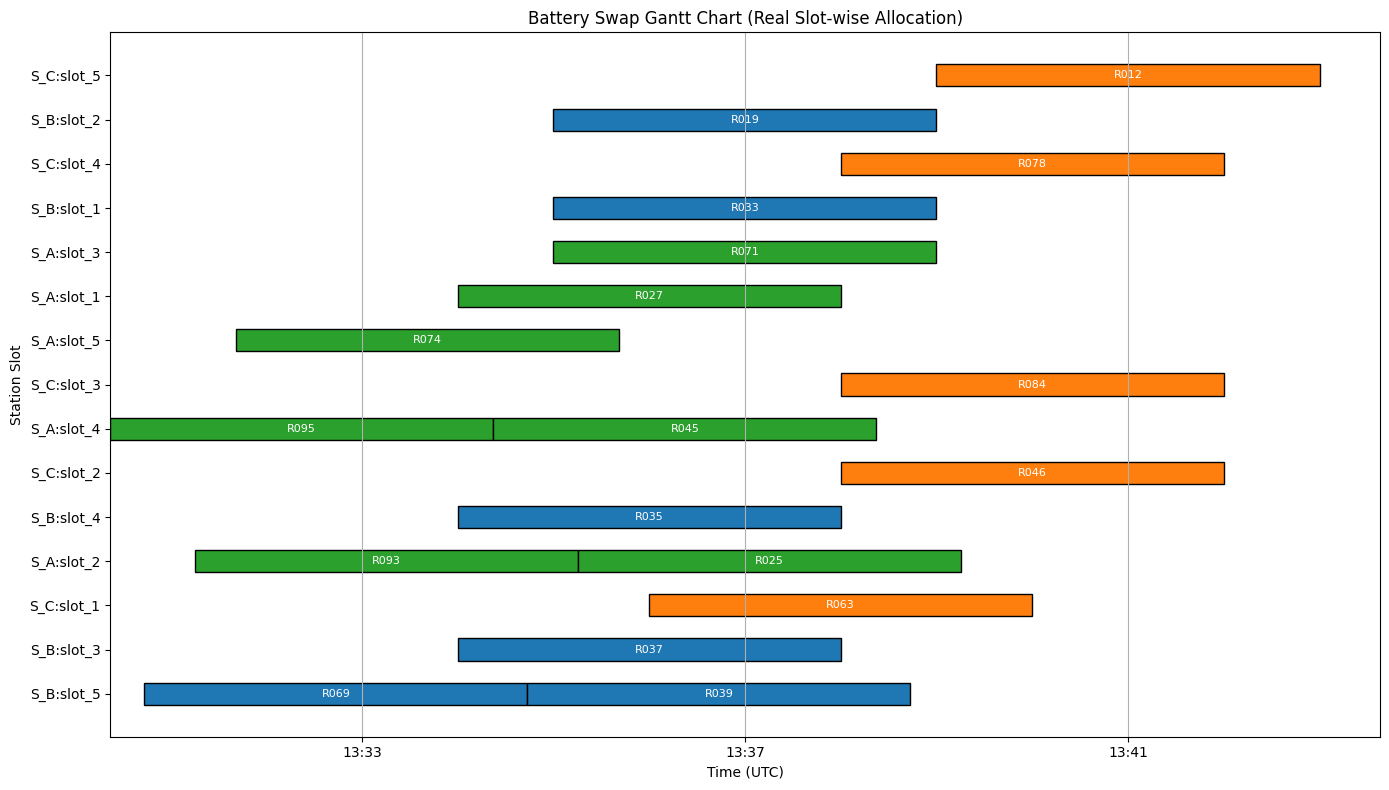

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load data
plan_df = pd.read_csv("plan_output_slot_based.csv")
plan_df["swap_start_ts"] = pd.to_datetime(plan_df["swap_start_ts"],format='ISO8601')
plan_df["swap_end_ts"] = pd.to_datetime(plan_df["swap_end_ts"],format='ISO8601')

# Create composite label for each slot
plan_df["slot_label"] = plan_df["station_id"] + ":" + plan_df["slot_used"]

# Assign color per station
station_colors = {
    s: c for s, c in zip(plan_df["station_id"].unique(), plt.cm.tab10.colors)
}

# Plot
fig, ax = plt.subplots(figsize=(14, 8))

for _, row in plan_df.iterrows():
    ax.barh(
        y=row["slot_label"],
        width=row["swap_end_ts"] - row["swap_start_ts"],
        left=row["swap_start_ts"],
        height=0.5,
        color=station_colors[row["station_id"]],
        edgecolor="black"
    )
    ax.text(
        row["swap_start_ts"] + (row["swap_end_ts"] - row["swap_start_ts"]) / 2,
        row["slot_label"],
        row["rider_id"],
        ha='center', va='center', fontsize=8, color='white'
    )

# Format time axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=4))
plt.xlabel("Time (UTC)")
plt.ylabel("Station Slot")
plt.title("Battery Swap Gantt Chart (Real Slot-wise Allocation)")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()
